In [1]:
from typing import List
import sys
from collections import defaultdict

import pandas as pd
import numpy as np
from tqdm.autonotebook import tqdm

from recsys4daos.models import OpenPop
from recsys4daos.datasets import to_microsoft
from recsys4daos.model_selection import cvtt_open
from recsys4daos.evaluation import calculate_all_metrics

import paths

import recommenders
if recommenders.__version__ == '1.2.0':
    print("Ignoring warnings")
    import warnings
    warnings.simplefilter(action='ignore', category=FutureWarning)

/tmp/ipykernel_3815531/2526015065.py:7: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


Ignoring warnings


In [2]:
SPLITS_FREQ = "W-THU"
SPLITS_NORMALIZE = True
ORG_NAME = 'Decentraland'
LAST_FOLD_DATE_STR: str = None # Won't use it, we will just calculate for every fold

# In this notebook this is just used for plotting and description, not "training"
# every fold is saved into the results table
LAST_FOLDS = 10

K_RECOMMENDATIONS: List[int] = [1,3,5,10,15,100]

In [3]:
# Parameters
EXECUTION_ID = "2024-09-04T10:00"
ORG_NAME = "HUWA-DAO"
SPLITS_FREQ = "2d"
LAST_FOLDS = 6
SPLITS_NORMALIZE = True
LAST_FOLD_DATE_STR = "2021-11-13"


## Obtain dataset

In [4]:
!pwd

/home/daviddavo/recsys4daos/notebooks


In [5]:
!md5sum ../data/decentraland/*

md5sum: '../data/decentraland/*': No such file or directory


In [6]:
dfp = paths.load_proposals(ORG_NAME)
dfv = paths.load_votes(ORG_NAME)

df = to_microsoft(dfv)

print(dfp.info())
print(dfv.info())
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 631 entries, 0 to 630
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   id                 631 non-null    object        
 1   author             631 non-null    object        
 2   date               631 non-null    datetime64[us]
 3   start              631 non-null    datetime64[us]
 4   end                631 non-null    datetime64[us]
 5   platform_proposal  631 non-null    object        
dtypes: datetime64[us](3), object(3)
memory usage: 29.7+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4151 entries, 0 to 4150
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   id        4151 non-null   object        
 1   proposal  4151 non-null   object        
 2   voter     4151 non-null   object        
 3   date      4151 non-null   datetime64[us]
dtypes: d

## Showing some info of the folds

In [7]:
sdd = defaultdict(list)

for dftrain, dftest, t, openproposals in cvtt_open(to_microsoft(dfv), SPLITS_FREQ, dfp.reset_index(), remove_not_in_train_col='userID', normalize=SPLITS_NORMALIZE):
    dftrain_filter = dftrain[dftrain['itemID'].isin(openproposals)]
    
    sdd['fold'].append(t)
    sdd['open proposals'].append(len(openproposals))
    
    sdd['proposals in train'].append(dftrain['itemID'].nunique())
    sdd['votes in train'].append(len(dftrain))
    sdd['votes in open proposals (train)'].append(len(dftrain_filter))
    sdd['users in open proposals (train)'].append(dftrain_filter['userID'].nunique())
    sdd['votes in test'].append(len(dftest))
    sdd['users in train'].append(dftrain['userID'].nunique())
    sdd['users in test'].append(dftest['userID'].nunique())

sdf_all = pd.DataFrame(sdd).set_index('fold')
sdf_all['vpp in open proposals (train)'] = sdf_all['votes in open proposals (train)'] / sdf_all['open proposals']
sdf_all['vpu in open proposals (train)'] = sdf_all['votes in open proposals (train)'] / sdf_all['users in open proposals (train)']
sdf_all['vpp test'] = sdf_all['votes in test'] / sdf_all['open proposals']
sdf_all['vpu test'] = sdf_all['votes in test'] / sdf_all['users in test']
paths.save_folds_info(sdf_all, ORG_NAME, SPLITS_FREQ, SPLITS_NORMALIZE)
sdf = sdf_all.tail(LAST_FOLDS)
print(sdf['votes in train'])
_style = sdf[['open proposals', 'votes in open proposals (train)', 'users in open proposals (train)', 'vpp in open proposals (train)', 'vpu in open proposals (train)', 'votes in test', 'users in test', 'vpp test', 'vpu test']].style
_style = _style.format_index('{:%G-W%V}').format(precision=2)
_style

Saved dataframe into /home/daviddavo/recsys4daos/data/output/HUWA-DAO/baseline/folds-info_2d_normalize.parquet
fold
2023-06-20    4066
2023-06-22    4069
2023-06-24    4073
2023-06-26    4081
2023-06-28    4099
2023-06-30    4136
Name: votes in train, dtype: int64


,open proposals,votes in open proposals (train),users in open proposals (train),vpp in open proposals (train),vpu in open proposals (train),votes in test,users in test,vpp test,vpu test
fold,,,,,,,,,
2023-W25,3,83,41,27.67,2.02,13,9,4.33,1.44
2023-W25,2,75,42,37.50,1.79,10,7,5.00,1.43
2023-W25,2,79,44,39.50,1.80,6,4,3.00,1.50
2023-W26,4,87,48,21.75,1.81,13,6,3.25,2.17
2023-W26,5,105,49,21.00,2.14,2,2,0.40,1.00
2023-W26,4,49,38,12.25,1.29,6,2,1.50,3.00


In [8]:
print(_style
  .format_index("\\textbf{{{}}}", escape="latex", axis=1)
  .to_latex()
)

\begin{tabular}{lrrrrrrrrr}
 & \textbf{open proposals} & \textbf{votes in open proposals (train)} & \textbf{users in open proposals (train)} & \textbf{vpp in open proposals (train)} & \textbf{vpu in open proposals (train)} & \textbf{votes in test} & \textbf{users in test} & \textbf{vpp test} & \textbf{vpu test} \\
fold &  &  &  &  &  &  &  &  &  \\
2023-W25 & 3 & 83 & 41 & 27.67 & 2.02 & 13 & 9 & 4.33 & 1.44 \\
2023-W25 & 2 & 75 & 42 & 37.50 & 1.79 & 10 & 7 & 5.00 & 1.43 \\
2023-W25 & 2 & 79 & 44 & 39.50 & 1.80 & 6 & 4 & 3.00 & 1.50 \\
2023-W26 & 4 & 87 & 48 & 21.75 & 1.81 & 13 & 6 & 3.25 & 2.17 \\
2023-W26 & 5 & 105 & 49 & 21.00 & 2.14 & 2 & 2 & 0.40 & 1.00 \\
2023-W26 & 4 & 49 & 38 & 12.25 & 1.29 & 6 & 2 & 1.50 & 3.00 \\
\end{tabular}



## Running openpop baseline

In [9]:
WARNING_AT_LEAST_OPEN = 5

folds = list(cvtt_open(df, SPLITS_FREQ, dfp, remove_not_in_train_col='userID', normalize=SPLITS_NORMALIZE))
metrics = []
perfectmetrics = []

first_empty = True
ok_in_a_row = best_in_a_row = 0
max_ok_in_a_row = (-1, folds[-1].end)
for i, (train, test, t, open_proposals) in enumerate(tqdm(folds)):   
    if first_empty:
        if not train.empty:
            first_empty = False
    else:
        assert not train.empty, f"Train should not be empty on fold {i}"
    if test.empty:
        print(f"Warning, empty test fold {i} ({t}), all ok since {ok_in_a_row} folds ago", file=sys.stderr)
        if ok_in_a_row > max_ok_in_a_row[0]:
            max_ok_in_a_row = (ok_in_a_row, t)
        ok_in_a_row = best_in_a_row = 0
    elif len(open_proposals) < WARNING_AT_LEAST_OPEN:
        print(f"Warning, test fold {i} ({t}) with less than {WARNING_AT_LEAST_OPEN} open proposals ({len(open_proposals)}). all ok since {best_in_a_row} folds ago", file=sys.stderr)
        best_in_a_row = 0

    mdict = {'fold': t}
    pdict = {'fold': t}
    model = OpenPop(train)
    recs = model.recommend_k_items(test['userID'].unique(), max(K_RECOMMENDATIONS), recommend_from=open_proposals)
    mdict |= calculate_all_metrics(test, recs, K_RECOMMENDATIONS)
        # for m, f in metrics_f.items():
        #     r = f(test, recs, k=k_recs)
        #     metrics[m+f'@{k_recs}'].append(r)
    
    recs = test.copy()
    recs['prediction'] = 1
    pdict |= calculate_all_metrics(test, recs, K_RECOMMENDATIONS)

        # for m, f in metrics_f.items():
        #     # Need relevancy_method=None as they are unsorted
        #     r = f(test, recs, k=k_recs)
        #     perfectmetrics[m+f'@{k_recs}'].append(r)

    metrics.append(mdict)
    perfectmetrics.append(pdict)
    ok_in_a_row += 1
    best_in_a_row += 1

paths.save_dao_datum(ORG_NAME, 'max_ok_folds', str(max_ok_in_a_row[0]))
paths.save_dao_datum(ORG_NAME, 'max_ok_folds_date', str(max_ok_in_a_row[1]))
if max_ok_in_a_row == -1:
    print("All ok :>")
else:
    print("Max ok in a row:", max_ok_in_a_row)

  0%|          | 0/355 [00:00<?, ?it/s]

Warning, empty test fold 0 (2021-07-22 00:00:00), all ok since 0 folds ago
Warning, empty test fold 1 (2021-07-24 00:00:00), all ok since 1 folds ago


Warning, empty test fold 2 (2021-07-26 00:00:00), all ok since 1 folds ago
Warning, empty test fold 3 (2021-07-28 00:00:00), all ok since 1 folds ago


Warning, empty test fold 4 (2021-07-30 00:00:00), all ok since 1 folds ago
Warning, empty test fold 5 (2021-08-01 00:00:00), all ok since 1 folds ago


Warning, empty test fold 6 (2021-08-03 00:00:00), all ok since 1 folds ago
Warning, empty test fold 7 (2021-08-05 00:00:00), all ok since 1 folds ago


Warning, empty test fold 8 (2021-08-07 00:00:00), all ok since 1 folds ago
Warning, empty test fold 9 (2021-08-09 00:00:00), all ok since 1 folds ago


Warning, test fold 10 (2021-08-11 00:00:00) with less than 5 open proposals (3). all ok since 1 folds ago


Warning, empty test fold 11 (2021-08-13 00:00:00), all ok since 2 folds ago
Warning, empty test fold 12 (2021-08-15 00:00:00), all ok since 1 folds ago


Warning, empty test fold 13 (2021-08-17 00:00:00), all ok since 1 folds ago
Warning, empty test fold 14 (2021-08-19 00:00:00), all ok since 1 folds ago


Warning, empty test fold 15 (2021-08-21 00:00:00), all ok since 1 folds ago
Warning, empty test fold 16 (2021-08-23 00:00:00), all ok since 1 folds ago


Warning, empty test fold 17 (2021-08-25 00:00:00), all ok since 1 folds ago
Warning, empty test fold 18 (2021-08-27 00:00:00), all ok since 1 folds ago


Warning, empty test fold 19 (2021-08-29 00:00:00), all ok since 1 folds ago
Warning, empty test fold 20 (2021-08-31 00:00:00), all ok since 1 folds ago


Warning, empty test fold 21 (2021-09-02 00:00:00), all ok since 1 folds ago
Warning, empty test fold 22 (2021-09-04 00:00:00), all ok since 1 folds ago


Warning, empty test fold 23 (2021-09-06 00:00:00), all ok since 1 folds ago
Warning, empty test fold 24 (2021-09-08 00:00:00), all ok since 1 folds ago


Warning, empty test fold 25 (2021-09-10 00:00:00), all ok since 1 folds ago
Warning, empty test fold 26 (2021-09-12 00:00:00), all ok since 1 folds ago


Warning, empty test fold 27 (2021-09-14 00:00:00), all ok since 1 folds ago
Warning, empty test fold 28 (2021-09-16 00:00:00), all ok since 1 folds ago


Warning, empty test fold 29 (2021-09-18 00:00:00), all ok since 1 folds ago
Warning, empty test fold 30 (2021-09-20 00:00:00), all ok since 1 folds ago


Warning, empty test fold 31 (2021-09-22 00:00:00), all ok since 1 folds ago
Warning, empty test fold 32 (2021-09-24 00:00:00), all ok since 1 folds ago


Warning, empty test fold 33 (2021-09-26 00:00:00), all ok since 1 folds ago
Warning, empty test fold 34 (2021-09-28 00:00:00), all ok since 1 folds ago


Warning, empty test fold 35 (2021-09-30 00:00:00), all ok since 1 folds ago
Warning, empty test fold 36 (2021-10-02 00:00:00), all ok since 1 folds ago


Warning, empty test fold 37 (2021-10-04 00:00:00), all ok since 1 folds ago
Warning, empty test fold 38 (2021-10-06 00:00:00), all ok since 1 folds ago


Warning, empty test fold 39 (2021-10-08 00:00:00), all ok since 1 folds ago
Warning, test fold 40 (2021-10-10 00:00:00) with less than 5 open proposals (1). all ok since 1 folds ago


Warning, test fold 41 (2021-10-12 00:00:00) with less than 5 open proposals (2). all ok since 1 folds ago


Warning, test fold 42 (2021-10-14 00:00:00) with less than 5 open proposals (2). all ok since 1 folds ago


Warning, test fold 43 (2021-10-16 00:00:00) with less than 5 open proposals (2). all ok since 1 folds ago


Warning, test fold 44 (2021-10-18 00:00:00) with less than 5 open proposals (2). all ok since 1 folds ago


Warning, test fold 45 (2021-10-20 00:00:00) with less than 5 open proposals (2). all ok since 1 folds ago


Warning, test fold 46 (2021-10-22 00:00:00) with less than 5 open proposals (2). all ok since 1 folds ago


Warning, test fold 47 (2021-10-24 00:00:00) with less than 5 open proposals (2). all ok since 1 folds ago


Warning, test fold 48 (2021-10-26 00:00:00) with less than 5 open proposals (2). all ok since 1 folds ago


Warning, test fold 82 (2022-01-02 00:00:00) with less than 5 open proposals (4). all ok since 34 folds ago


Warning, empty test fold 96 (2022-01-30 00:00:00), all ok since 57 folds ago
Warning, empty test fold 97 (2022-02-01 00:00:00), all ok since 1 folds ago


Warning, empty test fold 98 (2022-02-03 00:00:00), all ok since 1 folds ago
Warning, empty test fold 99 (2022-02-05 00:00:00), all ok since 1 folds ago


Warning, empty test fold 100 (2022-02-07 00:00:00), all ok since 1 folds ago
Warning, empty test fold 101 (2022-02-09 00:00:00), all ok since 1 folds ago


Warning, empty test fold 102 (2022-02-11 00:00:00), all ok since 1 folds ago
Warning, empty test fold 103 (2022-02-13 00:00:00), all ok since 1 folds ago


Warning, empty test fold 104 (2022-02-15 00:00:00), all ok since 1 folds ago
Warning, empty test fold 105 (2022-02-17 00:00:00), all ok since 1 folds ago


Warning, empty test fold 106 (2022-02-19 00:00:00), all ok since 1 folds ago
Warning, empty test fold 107 (2022-02-21 00:00:00), all ok since 1 folds ago


Warning, test fold 108 (2022-02-23 00:00:00) with less than 5 open proposals (2). all ok since 1 folds ago


Warning, empty test fold 109 (2022-02-25 00:00:00), all ok since 2 folds ago
Warning, empty test fold 110 (2022-02-27 00:00:00), all ok since 1 folds ago


Warning, empty test fold 111 (2022-03-01 00:00:00), all ok since 1 folds ago
Warning, empty test fold 112 (2022-03-03 00:00:00), all ok since 1 folds ago


Warning, empty test fold 113 (2022-03-05 00:00:00), all ok since 1 folds ago
Warning, empty test fold 114 (2022-03-07 00:00:00), all ok since 1 folds ago


Warning, empty test fold 115 (2022-03-09 00:00:00), all ok since 1 folds ago
Warning, empty test fold 116 (2022-03-11 00:00:00), all ok since 1 folds ago


Warning, empty test fold 117 (2022-03-13 00:00:00), all ok since 1 folds ago
Warning, empty test fold 118 (2022-03-15 00:00:00), all ok since 1 folds ago


Warning, empty test fold 119 (2022-03-17 00:00:00), all ok since 1 folds ago
Warning, empty test fold 120 (2022-03-19 00:00:00), all ok since 1 folds ago


Warning, empty test fold 121 (2022-03-21 00:00:00), all ok since 1 folds ago
Warning, empty test fold 122 (2022-03-23 00:00:00), all ok since 1 folds ago


Warning, test fold 123 (2022-03-25 00:00:00) with less than 5 open proposals (1). all ok since 1 folds ago


Warning, test fold 124 (2022-03-27 00:00:00) with less than 5 open proposals (1). all ok since 1 folds ago


Warning, test fold 125 (2022-03-29 00:00:00) with less than 5 open proposals (1). all ok since 1 folds ago


Warning, empty test fold 126 (2022-03-31 00:00:00), all ok since 4 folds ago
Warning, empty test fold 127 (2022-04-02 00:00:00), all ok since 1 folds ago


Warning, empty test fold 128 (2022-04-04 00:00:00), all ok since 1 folds ago
Warning, empty test fold 129 (2022-04-06 00:00:00), all ok since 1 folds ago


Warning, empty test fold 130 (2022-04-08 00:00:00), all ok since 1 folds ago
Warning, empty test fold 131 (2022-04-10 00:00:00), all ok since 1 folds ago


Warning, empty test fold 132 (2022-04-12 00:00:00), all ok since 1 folds ago
Warning, empty test fold 133 (2022-04-14 00:00:00), all ok since 1 folds ago


Warning, empty test fold 134 (2022-04-16 00:00:00), all ok since 1 folds ago
Warning, empty test fold 135 (2022-04-18 00:00:00), all ok since 1 folds ago


Warning, empty test fold 136 (2022-04-20 00:00:00), all ok since 1 folds ago
Warning, empty test fold 137 (2022-04-22 00:00:00), all ok since 1 folds ago


Warning, empty test fold 138 (2022-04-24 00:00:00), all ok since 1 folds ago
Warning, empty test fold 139 (2022-04-26 00:00:00), all ok since 1 folds ago


Warning, empty test fold 140 (2022-04-28 00:00:00), all ok since 1 folds ago
Warning, empty test fold 141 (2022-04-30 00:00:00), all ok since 1 folds ago


Warning, empty test fold 142 (2022-05-02 00:00:00), all ok since 1 folds ago
Warning, empty test fold 143 (2022-05-04 00:00:00), all ok since 1 folds ago


Warning, empty test fold 144 (2022-05-06 00:00:00), all ok since 1 folds ago
Warning, test fold 145 (2022-05-08 00:00:00) with less than 5 open proposals (1). all ok since 1 folds ago


Warning, test fold 146 (2022-05-10 00:00:00) with less than 5 open proposals (1). all ok since 1 folds ago


Warning, test fold 147 (2022-05-12 00:00:00) with less than 5 open proposals (1). all ok since 1 folds ago


Warning, empty test fold 148 (2022-05-14 00:00:00), all ok since 4 folds ago
Warning, empty test fold 149 (2022-05-16 00:00:00), all ok since 1 folds ago


Warning, empty test fold 150 (2022-05-18 00:00:00), all ok since 1 folds ago
Warning, empty test fold 151 (2022-05-20 00:00:00), all ok since 1 folds ago


Warning, empty test fold 152 (2022-05-22 00:00:00), all ok since 1 folds ago
Warning, empty test fold 153 (2022-05-24 00:00:00), all ok since 1 folds ago


Warning, empty test fold 154 (2022-05-26 00:00:00), all ok since 1 folds ago
Warning, empty test fold 155 (2022-05-28 00:00:00), all ok since 1 folds ago


Warning, empty test fold 156 (2022-05-30 00:00:00), all ok since 1 folds ago
Warning, empty test fold 157 (2022-06-01 00:00:00), all ok since 1 folds ago


Warning, empty test fold 158 (2022-06-03 00:00:00), all ok since 1 folds ago
Warning, test fold 159 (2022-06-05 00:00:00) with less than 5 open proposals (1). all ok since 1 folds ago


Warning, test fold 160 (2022-06-07 00:00:00) with less than 5 open proposals (2). all ok since 1 folds ago


Warning, test fold 161 (2022-06-09 00:00:00) with less than 5 open proposals (2). all ok since 1 folds ago


Warning, empty test fold 162 (2022-06-11 00:00:00), all ok since 4 folds ago
Warning, test fold 163 (2022-06-13 00:00:00) with less than 5 open proposals (1). all ok since 1 folds ago


Warning, test fold 164 (2022-06-15 00:00:00) with less than 5 open proposals (2). all ok since 1 folds ago


Warning, test fold 165 (2022-06-17 00:00:00) with less than 5 open proposals (1). all ok since 1 folds ago


Warning, test fold 166 (2022-06-19 00:00:00) with less than 5 open proposals (1). all ok since 1 folds ago


Warning, test fold 167 (2022-06-21 00:00:00) with less than 5 open proposals (1). all ok since 1 folds ago


Warning, test fold 168 (2022-06-23 00:00:00) with less than 5 open proposals (1). all ok since 1 folds ago


Warning, empty test fold 169 (2022-06-25 00:00:00), all ok since 7 folds ago
Warning, empty test fold 170 (2022-06-27 00:00:00), all ok since 1 folds ago


Warning, empty test fold 171 (2022-06-29 00:00:00), all ok since 1 folds ago
Warning, empty test fold 172 (2022-07-01 00:00:00), all ok since 1 folds ago


Warning, empty test fold 173 (2022-07-03 00:00:00), all ok since 1 folds ago
Warning, empty test fold 174 (2022-07-05 00:00:00), all ok since 1 folds ago


Warning, empty test fold 175 (2022-07-07 00:00:00), all ok since 1 folds ago
Warning, empty test fold 176 (2022-07-09 00:00:00), all ok since 1 folds ago


Warning, empty test fold 177 (2022-07-11 00:00:00), all ok since 1 folds ago
Warning, empty test fold 178 (2022-07-13 00:00:00), all ok since 1 folds ago


Warning, test fold 179 (2022-07-15 00:00:00) with less than 5 open proposals (1). all ok since 1 folds ago


Warning, test fold 180 (2022-07-17 00:00:00) with less than 5 open proposals (1). all ok since 1 folds ago


Warning, test fold 181 (2022-07-19 00:00:00) with less than 5 open proposals (1). all ok since 1 folds ago


Warning, test fold 182 (2022-07-21 00:00:00) with less than 5 open proposals (1). all ok since 1 folds ago


Warning, test fold 183 (2022-07-23 00:00:00) with less than 5 open proposals (1). all ok since 1 folds ago


Warning, test fold 184 (2022-07-25 00:00:00) with less than 5 open proposals (1). all ok since 1 folds ago


Warning, test fold 185 (2022-07-27 00:00:00) with less than 5 open proposals (1). all ok since 1 folds ago


Warning, empty test fold 186 (2022-07-29 00:00:00), all ok since 8 folds ago
Warning, empty test fold 187 (2022-07-31 00:00:00), all ok since 1 folds ago


Warning, empty test fold 188 (2022-08-02 00:00:00), all ok since 1 folds ago
Warning, empty test fold 189 (2022-08-04 00:00:00), all ok since 1 folds ago


Warning, empty test fold 190 (2022-08-06 00:00:00), all ok since 1 folds ago
Warning, empty test fold 191 (2022-08-08 00:00:00), all ok since 1 folds ago


Warning, empty test fold 192 (2022-08-10 00:00:00), all ok since 1 folds ago
Warning, empty test fold 193 (2022-08-12 00:00:00), all ok since 1 folds ago


Warning, empty test fold 194 (2022-08-14 00:00:00), all ok since 1 folds ago
Warning, empty test fold 195 (2022-08-16 00:00:00), all ok since 1 folds ago


Warning, empty test fold 196 (2022-08-18 00:00:00), all ok since 1 folds ago
Warning, empty test fold 197 (2022-08-20 00:00:00), all ok since 1 folds ago


Warning, empty test fold 198 (2022-08-22 00:00:00), all ok since 1 folds ago
Warning, empty test fold 199 (2022-08-24 00:00:00), all ok since 1 folds ago


Warning, empty test fold 200 (2022-08-26 00:00:00), all ok since 1 folds ago
Warning, test fold 201 (2022-08-28 00:00:00) with less than 5 open proposals (1). all ok since 1 folds ago


Warning, empty test fold 202 (2022-08-30 00:00:00), all ok since 2 folds ago
Warning, empty test fold 203 (2022-09-01 00:00:00), all ok since 1 folds ago


Warning, empty test fold 204 (2022-09-03 00:00:00), all ok since 1 folds ago
Warning, empty test fold 205 (2022-09-05 00:00:00), all ok since 1 folds ago


Warning, empty test fold 206 (2022-09-07 00:00:00), all ok since 1 folds ago
Warning, empty test fold 207 (2022-09-09 00:00:00), all ok since 1 folds ago


Warning, empty test fold 208 (2022-09-11 00:00:00), all ok since 1 folds ago
Warning, empty test fold 209 (2022-09-13 00:00:00), all ok since 1 folds ago


Warning, empty test fold 210 (2022-09-15 00:00:00), all ok since 1 folds ago
Warning, empty test fold 211 (2022-09-17 00:00:00), all ok since 1 folds ago


Warning, empty test fold 212 (2022-09-19 00:00:00), all ok since 1 folds ago
Warning, empty test fold 213 (2022-09-21 00:00:00), all ok since 1 folds ago


Warning, empty test fold 214 (2022-09-23 00:00:00), all ok since 1 folds ago
Warning, empty test fold 215 (2022-09-25 00:00:00), all ok since 1 folds ago


Warning, empty test fold 216 (2022-09-27 00:00:00), all ok since 1 folds ago
Warning, empty test fold 217 (2022-09-29 00:00:00), all ok since 1 folds ago


Warning, empty test fold 218 (2022-10-01 00:00:00), all ok since 1 folds ago
Warning, empty test fold 219 (2022-10-03 00:00:00), all ok since 1 folds ago


Warning, empty test fold 220 (2022-10-05 00:00:00), all ok since 1 folds ago
Warning, empty test fold 221 (2022-10-07 00:00:00), all ok since 1 folds ago


Warning, empty test fold 222 (2022-10-09 00:00:00), all ok since 1 folds ago
Warning, empty test fold 223 (2022-10-11 00:00:00), all ok since 1 folds ago


Warning, empty test fold 224 (2022-10-13 00:00:00), all ok since 1 folds ago
Warning, empty test fold 225 (2022-10-15 00:00:00), all ok since 1 folds ago


Warning, empty test fold 226 (2022-10-17 00:00:00), all ok since 1 folds ago
Warning, empty test fold 227 (2022-10-19 00:00:00), all ok since 1 folds ago


Warning, empty test fold 228 (2022-10-21 00:00:00), all ok since 1 folds ago
Warning, empty test fold 229 (2022-10-23 00:00:00), all ok since 1 folds ago


Warning, empty test fold 230 (2022-10-25 00:00:00), all ok since 1 folds ago
Warning, test fold 231 (2022-10-27 00:00:00) with less than 5 open proposals (1). all ok since 1 folds ago


Warning, empty test fold 232 (2022-10-29 00:00:00), all ok since 2 folds ago
Warning, test fold 233 (2022-10-31 00:00:00) with less than 5 open proposals (1). all ok since 1 folds ago


Warning, test fold 234 (2022-11-02 00:00:00) with less than 5 open proposals (1). all ok since 1 folds ago


Warning, empty test fold 235 (2022-11-04 00:00:00), all ok since 3 folds ago
Warning, empty test fold 236 (2022-11-06 00:00:00), all ok since 1 folds ago


Warning, empty test fold 237 (2022-11-08 00:00:00), all ok since 1 folds ago
Warning, test fold 238 (2022-11-10 00:00:00) with less than 5 open proposals (1). all ok since 1 folds ago


Warning, empty test fold 239 (2022-11-12 00:00:00), all ok since 2 folds ago
Warning, empty test fold 240 (2022-11-14 00:00:00), all ok since 1 folds ago


Warning, empty test fold 241 (2022-11-16 00:00:00), all ok since 1 folds ago
Warning, test fold 242 (2022-11-18 00:00:00) with less than 5 open proposals (1). all ok since 1 folds ago


Warning, test fold 243 (2022-11-20 00:00:00) with less than 5 open proposals (3). all ok since 1 folds ago


Warning, test fold 244 (2022-11-22 00:00:00) with less than 5 open proposals (2). all ok since 1 folds ago


Warning, test fold 245 (2022-11-24 00:00:00) with less than 5 open proposals (1). all ok since 1 folds ago


Warning, test fold 246 (2022-11-26 00:00:00) with less than 5 open proposals (1). all ok since 1 folds ago


Warning, test fold 247 (2022-11-28 00:00:00) with less than 5 open proposals (2). all ok since 1 folds ago


Warning, test fold 248 (2022-11-30 00:00:00) with less than 5 open proposals (2). all ok since 1 folds ago


Warning, empty test fold 249 (2022-12-02 00:00:00), all ok since 8 folds ago
Warning, empty test fold 250 (2022-12-04 00:00:00), all ok since 1 folds ago


Warning, empty test fold 251 (2022-12-06 00:00:00), all ok since 1 folds ago
Warning, empty test fold 252 (2022-12-08 00:00:00), all ok since 1 folds ago


Warning, empty test fold 253 (2022-12-10 00:00:00), all ok since 1 folds ago
Warning, empty test fold 254 (2022-12-12 00:00:00), all ok since 1 folds ago


Warning, empty test fold 255 (2022-12-14 00:00:00), all ok since 1 folds ago
Warning, empty test fold 256 (2022-12-16 00:00:00), all ok since 1 folds ago


Warning, empty test fold 257 (2022-12-18 00:00:00), all ok since 1 folds ago
Warning, empty test fold 258 (2022-12-20 00:00:00), all ok since 1 folds ago


Warning, empty test fold 259 (2022-12-22 00:00:00), all ok since 1 folds ago
Warning, empty test fold 260 (2022-12-24 00:00:00), all ok since 1 folds ago


Warning, empty test fold 261 (2022-12-26 00:00:00), all ok since 1 folds ago
Warning, empty test fold 262 (2022-12-28 00:00:00), all ok since 1 folds ago


Warning, empty test fold 263 (2022-12-30 00:00:00), all ok since 1 folds ago
Warning, empty test fold 264 (2023-01-01 00:00:00), all ok since 1 folds ago


Warning, empty test fold 265 (2023-01-03 00:00:00), all ok since 1 folds ago
Warning, empty test fold 266 (2023-01-05 00:00:00), all ok since 1 folds ago


Warning, empty test fold 267 (2023-01-07 00:00:00), all ok since 1 folds ago
Warning, empty test fold 268 (2023-01-09 00:00:00), all ok since 1 folds ago


Warning, empty test fold 269 (2023-01-11 00:00:00), all ok since 1 folds ago
Warning, empty test fold 270 (2023-01-13 00:00:00), all ok since 1 folds ago


Warning, empty test fold 271 (2023-01-15 00:00:00), all ok since 1 folds ago
Warning, empty test fold 272 (2023-01-17 00:00:00), all ok since 1 folds ago


Warning, empty test fold 273 (2023-01-19 00:00:00), all ok since 1 folds ago
Warning, empty test fold 274 (2023-01-21 00:00:00), all ok since 1 folds ago


Warning, empty test fold 275 (2023-01-23 00:00:00), all ok since 1 folds ago
Warning, test fold 276 (2023-01-25 00:00:00) with less than 5 open proposals (1). all ok since 1 folds ago


Warning, empty test fold 277 (2023-01-27 00:00:00), all ok since 2 folds ago
Warning, empty test fold 278 (2023-01-29 00:00:00), all ok since 1 folds ago


Warning, empty test fold 279 (2023-01-31 00:00:00), all ok since 1 folds ago
Warning, empty test fold 280 (2023-02-02 00:00:00), all ok since 1 folds ago


Warning, empty test fold 281 (2023-02-04 00:00:00), all ok since 1 folds ago
Warning, empty test fold 282 (2023-02-06 00:00:00), all ok since 1 folds ago


Warning, empty test fold 283 (2023-02-08 00:00:00), all ok since 1 folds ago
Warning, empty test fold 284 (2023-02-10 00:00:00), all ok since 1 folds ago


Warning, test fold 285 (2023-02-12 00:00:00) with less than 5 open proposals (1). all ok since 1 folds ago


Warning, test fold 286 (2023-02-14 00:00:00) with less than 5 open proposals (1). all ok since 1 folds ago


Warning, test fold 287 (2023-02-16 00:00:00) with less than 5 open proposals (1). all ok since 1 folds ago


Warning, test fold 288 (2023-02-18 00:00:00) with less than 5 open proposals (1). all ok since 1 folds ago


Warning, test fold 289 (2023-02-20 00:00:00) with less than 5 open proposals (1). all ok since 1 folds ago


Warning, test fold 290 (2023-02-22 00:00:00) with less than 5 open proposals (1). all ok since 1 folds ago


Warning, test fold 291 (2023-02-24 00:00:00) with less than 5 open proposals (1). all ok since 1 folds ago


Warning, test fold 292 (2023-02-26 00:00:00) with less than 5 open proposals (2). all ok since 1 folds ago


Warning, test fold 293 (2023-02-28 00:00:00) with less than 5 open proposals (2). all ok since 1 folds ago


Warning, test fold 294 (2023-03-02 00:00:00) with less than 5 open proposals (1). all ok since 1 folds ago


Warning, test fold 295 (2023-03-04 00:00:00) with less than 5 open proposals (1). all ok since 1 folds ago


Warning, test fold 296 (2023-03-06 00:00:00) with less than 5 open proposals (1). all ok since 1 folds ago


Warning, test fold 297 (2023-03-08 00:00:00) with less than 5 open proposals (1). all ok since 1 folds ago


Warning, test fold 298 (2023-03-10 00:00:00) with less than 5 open proposals (1). all ok since 1 folds ago


Warning, test fold 299 (2023-03-12 00:00:00) with less than 5 open proposals (1). all ok since 1 folds ago


Warning, test fold 300 (2023-03-14 00:00:00) with less than 5 open proposals (2). all ok since 1 folds ago


Warning, test fold 301 (2023-03-16 00:00:00) with less than 5 open proposals (2). all ok since 1 folds ago


Warning, test fold 302 (2023-03-18 00:00:00) with less than 5 open proposals (2). all ok since 1 folds ago


Warning, test fold 303 (2023-03-20 00:00:00) with less than 5 open proposals (1). all ok since 1 folds ago


Warning, test fold 304 (2023-03-22 00:00:00) with less than 5 open proposals (1). all ok since 1 folds ago


Warning, test fold 305 (2023-03-24 00:00:00) with less than 5 open proposals (1). all ok since 1 folds ago


Warning, empty test fold 306 (2023-03-26 00:00:00), all ok since 22 folds ago
Warning, empty test fold 307 (2023-03-28 00:00:00), all ok since 1 folds ago


Warning, test fold 308 (2023-03-30 00:00:00) with less than 5 open proposals (1). all ok since 1 folds ago


Warning, empty test fold 309 (2023-04-01 00:00:00), all ok since 2 folds ago
Warning, test fold 310 (2023-04-03 00:00:00) with less than 5 open proposals (3). all ok since 1 folds ago


Warning, test fold 311 (2023-04-05 00:00:00) with less than 5 open proposals (2). all ok since 1 folds ago


Warning, test fold 312 (2023-04-07 00:00:00) with less than 5 open proposals (2). all ok since 1 folds ago


Warning, test fold 313 (2023-04-09 00:00:00) with less than 5 open proposals (1). all ok since 1 folds ago


Warning, test fold 314 (2023-04-11 00:00:00) with less than 5 open proposals (1). all ok since 1 folds ago


Warning, test fold 315 (2023-04-13 00:00:00) with less than 5 open proposals (1). all ok since 1 folds ago


Warning, test fold 316 (2023-04-15 00:00:00) with less than 5 open proposals (1). all ok since 1 folds ago


Warning, test fold 317 (2023-04-17 00:00:00) with less than 5 open proposals (1). all ok since 1 folds ago


Warning, test fold 318 (2023-04-19 00:00:00) with less than 5 open proposals (2). all ok since 1 folds ago


Warning, test fold 319 (2023-04-21 00:00:00) with less than 5 open proposals (2). all ok since 1 folds ago


Warning, test fold 320 (2023-04-23 00:00:00) with less than 5 open proposals (2). all ok since 1 folds ago


Warning, test fold 321 (2023-04-25 00:00:00) with less than 5 open proposals (2). all ok since 1 folds ago


Warning, test fold 322 (2023-04-27 00:00:00) with less than 5 open proposals (2). all ok since 1 folds ago


Warning, empty test fold 323 (2023-04-29 00:00:00), all ok since 14 folds ago
Warning, empty test fold 324 (2023-05-01 00:00:00), all ok since 1 folds ago


Warning, empty test fold 325 (2023-05-03 00:00:00), all ok since 1 folds ago
Warning, empty test fold 326 (2023-05-05 00:00:00), all ok since 1 folds ago


Warning, empty test fold 327 (2023-05-07 00:00:00), all ok since 1 folds ago
Warning, empty test fold 328 (2023-05-09 00:00:00), all ok since 1 folds ago


Warning, empty test fold 329 (2023-05-11 00:00:00), all ok since 1 folds ago
Warning, empty test fold 330 (2023-05-13 00:00:00), all ok since 1 folds ago


Warning, empty test fold 331 (2023-05-15 00:00:00), all ok since 1 folds ago
Warning, empty test fold 332 (2023-05-17 00:00:00), all ok since 1 folds ago


Warning, empty test fold 333 (2023-05-19 00:00:00), all ok since 1 folds ago
Warning, empty test fold 334 (2023-05-21 00:00:00), all ok since 1 folds ago


Warning, empty test fold 335 (2023-05-23 00:00:00), all ok since 1 folds ago
Warning, empty test fold 336 (2023-05-25 00:00:00), all ok since 1 folds ago


Warning, empty test fold 337 (2023-05-27 00:00:00), all ok since 1 folds ago
Warning, empty test fold 338 (2023-05-29 00:00:00), all ok since 1 folds ago


Warning, empty test fold 339 (2023-05-31 00:00:00), all ok since 1 folds ago
Warning, empty test fold 340 (2023-06-02 00:00:00), all ok since 1 folds ago


Warning, empty test fold 341 (2023-06-04 00:00:00), all ok since 1 folds ago
Warning, test fold 342 (2023-06-06 00:00:00) with less than 5 open proposals (1). all ok since 1 folds ago


Warning, test fold 343 (2023-06-08 00:00:00) with less than 5 open proposals (2). all ok since 1 folds ago


Warning, test fold 344 (2023-06-10 00:00:00) with less than 5 open proposals (2). all ok since 1 folds ago


Warning, test fold 345 (2023-06-12 00:00:00) with less than 5 open proposals (3). all ok since 1 folds ago


Warning, test fold 346 (2023-06-14 00:00:00) with less than 5 open proposals (3). all ok since 1 folds ago


Warning, test fold 347 (2023-06-16 00:00:00) with less than 5 open proposals (3). all ok since 1 folds ago


Warning, test fold 348 (2023-06-18 00:00:00) with less than 5 open proposals (3). all ok since 1 folds ago


Warning, test fold 349 (2023-06-20 00:00:00) with less than 5 open proposals (3). all ok since 1 folds ago


Warning, test fold 350 (2023-06-22 00:00:00) with less than 5 open proposals (2). all ok since 1 folds ago


Warning, test fold 351 (2023-06-24 00:00:00) with less than 5 open proposals (2). all ok since 1 folds ago


Warning, test fold 352 (2023-06-26 00:00:00) with less than 5 open proposals (4). all ok since 1 folds ago


Warning, test fold 354 (2023-06-30 00:00:00) with less than 5 open proposals (4). all ok since 2 folds ago


Max ok in a row: (57, Timestamp('2022-01-30 00:00:00'))


### Caching these results

In [10]:
odf = pd.DataFrame(metrics).set_index("fold")
paths.save_openpop(odf, ORG_NAME, SPLITS_FREQ, SPLITS_NORMALIZE)
odf.describe()

Saved dataframe into /home/daviddavo/recsys4daos/data/output/HUWA-DAO/baseline/openpop_2d_normalize.parquet


,precision@1,precision@3,precision@5,precision@10,precision@15,precision@100,ndcg@1,ndcg@3,ndcg@5,ndcg@10,...,recall@10,recall@15,recall@100,r-precision@1,r-precision@3,r-precision@5,r-precision@10,r-precision@15,r-precision@100,time_eval
count,355.000000,355.000000,355.000000,355.000000,355.000000,355.000000,355.000000,355.000000,355.000000,355.000000,...,355.000000,355.000000,355.000000,355.000000,346.000000,345.000000,344.000000,343.000000,343.000000,355.000000
mean,0.251727,0.125664,0.084749,0.045793,0.031244,0.005071,0.251483,0.287625,0.299494,0.307218,...,0.357214,0.361587,0.375077,0.267259,0.311707,0.315730,0.316998,0.318278,0.318834,0.091921
std,0.415071,0.178487,0.119211,0.062812,0.042451,0.007076,0.414973,0.422789,0.424976,0.425111,...,0.469380,0.470698,0.477000,0.412823,0.439307,0.440249,0.440627,0.441023,0.441194,0.029383
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.068216
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.069634
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.071080
75%,0.480769,0.333333,0.200000,0.100000,0.066667,0.010000,0.480769,0.770343,0.787007,0.787007,...,1.000000,1.000000,1.000000,0.690278,1.000000,1.000000,1.000000,1.000000,1.000000,0.121400
max,1.000000,0.666667,0.600000,0.300000,0.200000,0.045556,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.280668


In [11]:
pdf = pd.DataFrame(perfectmetrics).set_index("fold")
cols = [ c for c in pdf.columns if not c.startswith('time_') ]
paths.save_perfect(pdf, ORG_NAME, SPLITS_FREQ, SPLITS_NORMALIZE)
display(pdf.describe())
msk = (0 <= pdf[cols].min()) & (pdf[cols].max() <= 1)
if not all(msk):
    display(pdf.describe()[msk[~msk].index])
assert all( msk ), "There are metrics with wrong range"

Saved dataframe into /home/daviddavo/recsys4daos/data/output/HUWA-DAO/baseline/perfect_2d_normalize.parquet


,precision@1,precision@3,precision@5,precision@10,precision@15,precision@100,ndcg@1,ndcg@3,ndcg@5,ndcg@10,...,recall@10,recall@15,recall@100,r-precision@1,r-precision@3,r-precision@5,r-precision@10,r-precision@15,r-precision@100,time_eval
count,355.000000,355.000000,355.000000,355.000000,355.000000,355.000000,355.000000,355.000000,355.000000,355.000000,...,355.000000,355.000000,355.000000,355.000000,355.000000,355.000000,355.000000,355.000000,355.000000,355.000000
mean,0.397183,0.170358,0.104930,0.053257,0.035861,0.005465,0.397183,0.397183,0.397183,0.397183,...,0.396610,0.396857,0.397183,0.347147,0.393494,0.396001,0.396610,0.396857,0.397183,0.096068
std,0.490005,0.225216,0.140912,0.072995,0.050188,0.007939,0.490005,0.490005,0.490005,0.490005,...,0.489342,0.489619,0.490005,0.440465,0.485841,0.488696,0.489342,0.489619,0.490005,0.028247
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.072072
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.073329
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.074678
75%,1.000000,0.333333,0.200000,0.100000,0.066667,0.010000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,0.846688,1.000000,1.000000,1.000000,1.000000,1.000000,0.128269
max,1.000000,1.000000,0.600000,0.420000,0.346667,0.060000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.247211


## Plotting some graphs

,fold,precision@1,precision@3,precision@5,precision@10,precision@15,precision@100,ndcg@1,ndcg@3,ndcg@5,...,recall@100,r-precision@1,r-precision@3,r-precision@5,r-precision@10,r-precision@15,r-precision@100,time_eval,perfect precision@5,perfect precision@10
count,355,355.000000,355.000000,355.000000,355.000000,355.000000,355.000000,355.000000,355.000000,355.000000,...,355.000000,355.000000,346.000000,345.000000,344.000000,343.000000,343.000000,355.000000,0.0,0.0
mean,2022-07-11 00:00:00,0.251727,0.125664,0.084749,0.045793,0.031244,0.005071,0.251483,0.287625,0.299494,...,0.375077,0.267259,0.311707,0.315730,0.316998,0.318278,0.318834,0.091921,NaN,NaN
min,2021-07-22 00:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.068216,NaN,NaN
25%,2022-01-15 00:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.069634,NaN,NaN
50%,2022-07-11 00:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.071080,NaN,NaN
75%,2023-01-04 00:00:00,0.480769,0.333333,0.200000,0.100000,0.066667,0.010000,0.480769,0.770343,0.787007,...,1.000000,0.690278,1.000000,1.000000,1.000000,1.000000,1.000000,0.121400,NaN,NaN
max,2023-06-30 00:00:00,1.000000,0.666667,0.600000,0.300000,0.200000,0.045556,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.280668,NaN,NaN
std,NaN,0.415071,0.178487,0.119211,0.062812,0.042451,0.007076,0.414973,0.422789,0.424976,...,0.477000,0.412823,0.439307,0.440249,0.440627,0.441023,0.441194,0.029383,NaN,NaN


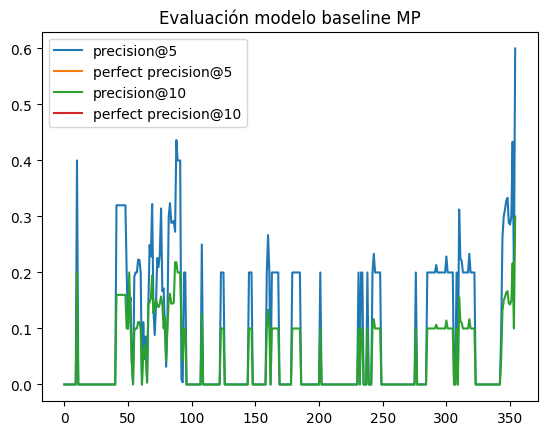

In [12]:
mdf = pd.DataFrame(metrics)
mdf['perfect precision@5'] = pdf['precision@5']
mdf['perfect precision@10'] = pdf['precision@10']
mdf[['precision@5', 'perfect precision@5', 'precision@10', 'perfect precision@10']].plot(title='Evaluación modelo baseline MP')
mdf.describe()

In [13]:
mdf[-LAST_FOLDS:].describe()

,fold,precision@1,precision@3,precision@5,precision@10,precision@15,precision@100,ndcg@1,ndcg@3,ndcg@5,...,recall@100,r-precision@1,r-precision@3,r-precision@5,r-precision@10,r-precision@15,r-precision@100,time_eval,perfect precision@5,perfect precision@10
count,6,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,...,6.0,6.000000,5.000000,5.000000,5.000000,5.000000,5.000000,6.000000,0.0,0.0
mean,2023-06-25 00:00:00,0.651455,0.492945,0.351323,0.175661,0.117108,0.017566,0.651455,0.766867,0.832789,...,1.0,0.475298,0.903333,0.913333,0.913333,0.913333,0.913333,0.121294,NaN,NaN
min,2023-06-20 00:00:00,0.000000,0.166667,0.200000,0.100000,0.066667,0.010000,0.000000,0.250000,0.443426,...,1.0,0.000000,0.666667,0.666667,0.666667,0.666667,0.666667,0.114003,NaN,NaN
25%,2023-06-22 12:00:00,0.678571,0.477513,0.286508,0.143254,0.095503,0.014325,0.678571,0.790413,0.872816,...,1.0,0.359375,0.850000,0.900000,0.900000,0.900000,0.900000,0.122248,NaN,NaN
50%,2023-06-25 00:00:00,0.732143,0.490741,0.294444,0.147222,0.098148,0.014722,0.732143,0.880061,0.901142,...,1.0,0.552083,1.000000,1.000000,1.000000,1.000000,1.000000,0.122445,NaN,NaN
75%,2023-06-27 12:00:00,0.770833,0.625000,0.400000,0.200000,0.133333,0.020000,0.770833,0.904437,0.915421,...,1.0,0.691667,1.000000,1.000000,1.000000,1.000000,1.000000,0.122981,NaN,NaN
max,2023-06-30 00:00:00,1.000000,0.666667,0.600000,0.300000,0.200000,0.030000,1.000000,0.917984,0.967468,...,1.0,0.714286,1.000000,1.000000,1.000000,1.000000,1.000000,0.123530,NaN,NaN
std,NaN,0.339330,0.182909,0.143039,0.071520,0.047680,0.007152,0.339330,0.259183,0.193652,...,0.0,0.279900,0.147385,0.144530,0.144530,0.144530,0.144530,0.003607,NaN,NaN
